# Setup

In [2]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

from gprofiler import GProfiler
from pathlib import Path

import os 

#doublet detection
import scrublet as scr

#batch correction (not installed by default in the docker container, install via command line: pip install scanorama bbknn)
import scanorama as scan

#external modules
import scanpy.external as sce

#pretty plotting
import seaborn as sb

#R interface
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)

sb.set_context(context='poster') # extra large legend, or talk or paper

In [2]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
#.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(DropletUtils)

# Read data

In [10]:
filenames = ['SC76_R1', 'SC76_R2', 'SC76_1N']
adatas = [sc.read_10x_mtx(filename, cache=True) for filename in filenames]
adata = adatas[0].concatenate(adatas[1:])
adata.obs['batch'].replace({'0':'R1', '1':'R2', '2':'N1'}, inplace=True)

... reading from cache file cache/SC76_R1-matrix.h5ad
... reading from cache file cache/SC76_R2-matrix.h5ad
... reading from cache file cache/SC76_1N-matrix.h5ad


# Merge velocity

In [11]:
import scvelo as scv
ladata = scv.read('merged.loom', cache=True)
ladata.var_names_make_unique()
adata = scv.utils.merge(adata, ladata)
del ladata
adata.write('data/0_merged_raw.h5ad')

... reading from cache file cache/merged.h5ad


# Preprocessing

In [12]:
adata = sc.read('data/0_merged_raw.h5ad')

In [13]:
adata

AnnData object with n_obs × n_vars = 14141 × 31053
    obs: 'batch', 'sample_batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'gene_ids', 'feature_types', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [9]:
# sparse_mat = adata_raw.X.T #sparse_mat = adata_raw.X.T.toarray()
# genes = adata_raw.var_names
# barcodes = adata_raw.obs_names

In [10]:
# %%R -i sparse_mat -i genes -i barcodes -o barcodes_filtered -o ambient_genes

# sce <- SingleCellExperiment(assays = list(counts = sparse_mat), colData=barcodes)
# rownames(sce) <- genes 
# ambient <- emptyDrops(counts(sce))
# is_cell <- ambient$FDR <= 0.05
# threshold_ambient <- 0.005
# ambient_genes <- names(ambient@metadata$ambient[ambient@metadata$ambient> threshold_ambient,])
# barcodes_filtered <- barcodes[which(is_cell)]

In [11]:
# adata = adata_raw[np.in1d(adata_raw.obs_names, barcodes_filtered)].copy()
# adata.write('data_filtered.h5ad')

In [12]:
#adata = sc.read('data_filtered.h5ad')

In [14]:
adata.obs['n_counts'] = adata.X.sum(axis = 1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(axis = 1)

mt_gene_mask = np.flatnonzero([gene.startswith('mt-') for gene in adata.var_names])
adata.obs['mt_frac'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1/adata.obs['n_counts']

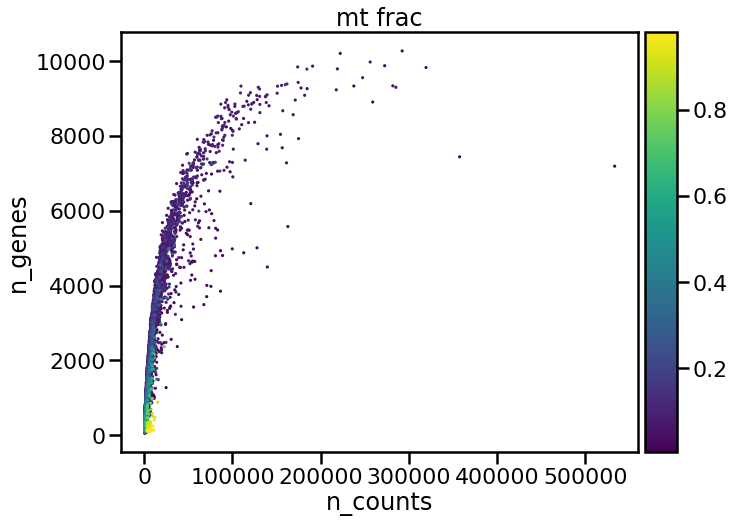

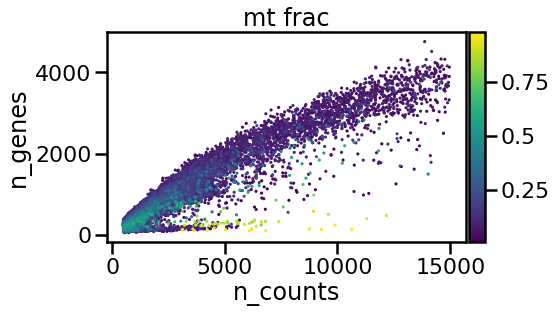

In [15]:
sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac', size=40);
sc.pl.scatter(adata[adata.obs['n_counts']<15000], 'n_counts', 'n_genes', color='mt_frac', size=40)

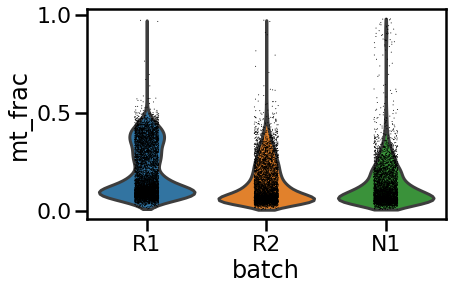

In [16]:
# sc.pl.violin(adata, 'n_counts', groupby='batch', size=2, log=True, cut=0)
sc.pl.violin(adata, 'mt_frac', groupby='batch')

## filter mt_frac

In [17]:
adata = adata[adata.obs['mt_frac'] < 0.25]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Number of cells after MT filter: 10753
filtered out 14581 genes that are detected in less than 20 cells
Number of genes after cell filter: 16472


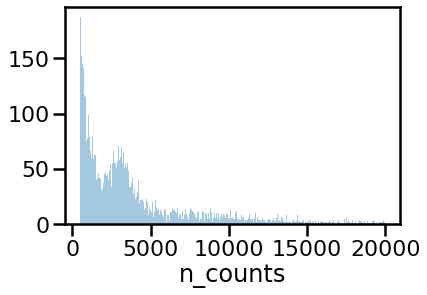

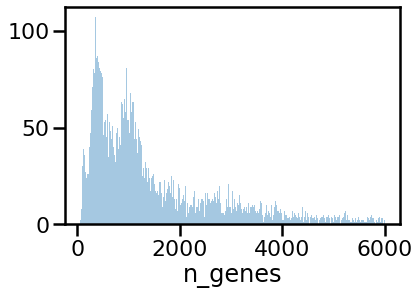

In [18]:
sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<20000], kde=False, bins=600);plt.show()
sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<6000], kde=False, bins=600);plt.show()

## filter counts

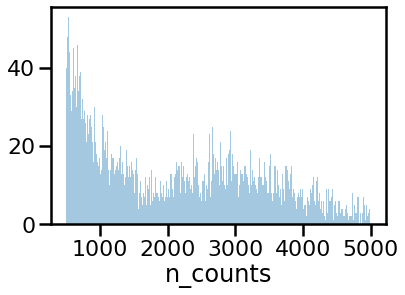

In [19]:
sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<5000], kde=False, bins=600);plt.show()

In [20]:
sc.pp.filter_cells(adata, min_counts = 1000)
print(f'#cells after min count filter: {adata.n_obs}')

sc.pp.filter_cells(adata, max_counts = 40000)
print(f'#cells after max count filter: {adata.n_obs}')

filtered out 1962 cells that have less than 1000 counts
#cells after min count filter: 8791
filtered out 379 cells that have more than 40000 counts
#cells after max count filter: 8412


## filter genes

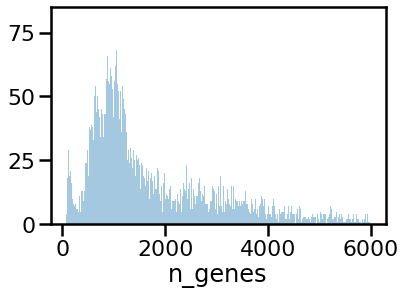

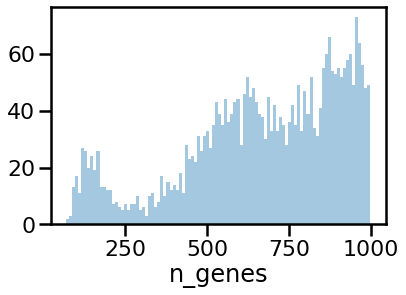

In [21]:
sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<6000], kde=False, bins=600);plt.show()
sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=100);plt.show()

In [22]:
sc.pp.filter_cells(adata, min_genes = 250)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

filtered out 268 cells that have less than 250 genes expressed
Number of cells after gene filter: 8144


## check

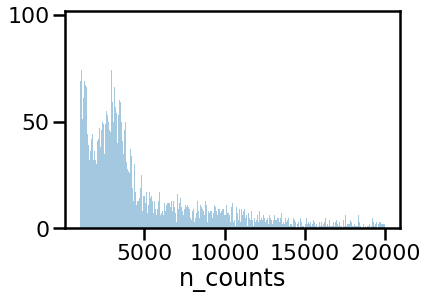

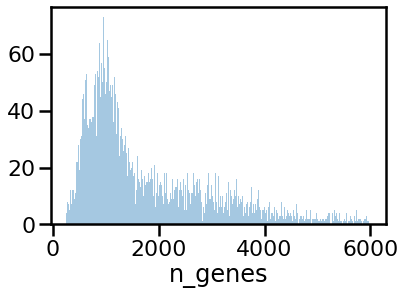

In [23]:
sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<20000], kde=False, bins=600);plt.show()
sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<6000], kde=False, bins=600);plt.show()

In [24]:
adata.write('data/1_cleaned.h5ad')

In [25]:
adata

AnnData object with n_obs × n_vars = 8144 × 16472
    obs: 'batch', 'sample_batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'log_counts', 'n_genes', 'mt_frac'
    var: 'gene_ids', 'feature_types', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells'
    uns: 'batch_colors'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

# Doublet

In [26]:
adata.obs['doublet_score']= np.zeros(adata.shape[0])
adata.obs['doublet'] = np.zeros(adata.shape[0])

In [27]:
# filtering/preprocessing parameters:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

# doublet detector parameters:
expected_doublet_rate = 0.02 
sim_doublet_ratio = 3
n_neighbors = 15



scrub = scr.Scrublet(counts_matrix = adata.X,  
                     n_neighbors = n_neighbors,
                     sim_doublet_ratio = sim_doublet_ratio,
                     expected_doublet_rate = expected_doublet_rate)

doublet_scores, predicted_doublets = scrub.scrub_doublets( 
                    min_counts = min_counts, 
                    min_cells = min_cells, 
                    n_prin_comps = n_pc,
                    use_approx_neighbors = True, 
                    get_doublet_neighbor_parents = False)

adata.obs['doublet_score'] = doublet_scores
adata.obs['doublet'] = predicted_doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 18.1%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 2.0%
Elapsed time: 10.0 seconds


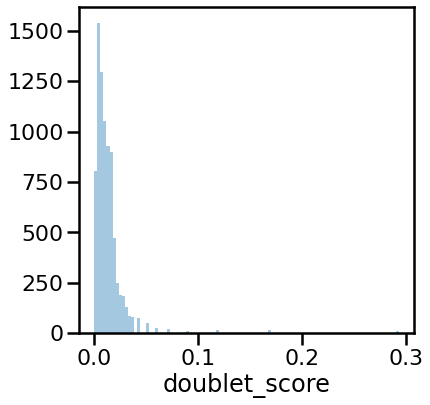

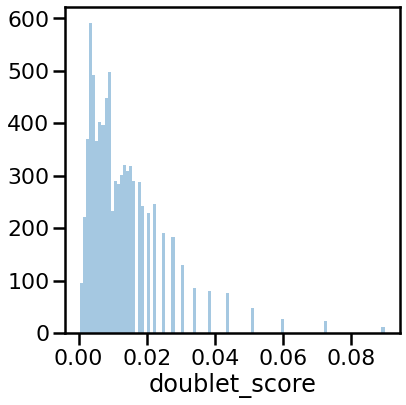

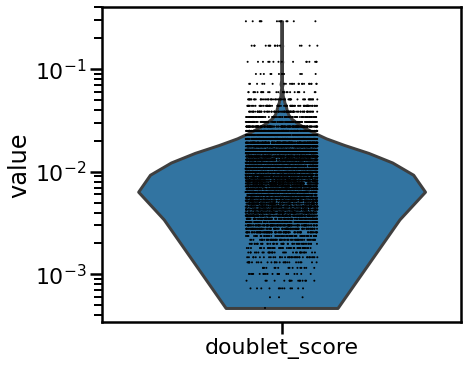

In [32]:
rcParams['figure.figsize']=(6,6)
sb.distplot(adata.obs['doublet_score'], bins=100, kde=False);plt.show()

sb.distplot(adata.obs['doublet_score'][adata.obs['doublet_score']<0.1], bins=100, kde=False) ;plt.show()



sc.pl.violin(adata, 'doublet_score',size=2, log=True, cut=0)


In [33]:
thr = 0.05
ix_filt = adata.obs['doublet_score']<=thr

adata = adata[ix_filt].copy()
print('Number of cells after doublet filter: {:d}'.format(adata.n_obs))

Number of cells after doublet filter: 7988


In [34]:
adata.write('data/1_cleaned.h5ad')

# Normalize

In [35]:
adata.layers['counts'] = adata.X.copy()
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [38]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T.toarray()

In [40]:
%%R -i data_mat -i input_groups -o size_factors

# size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

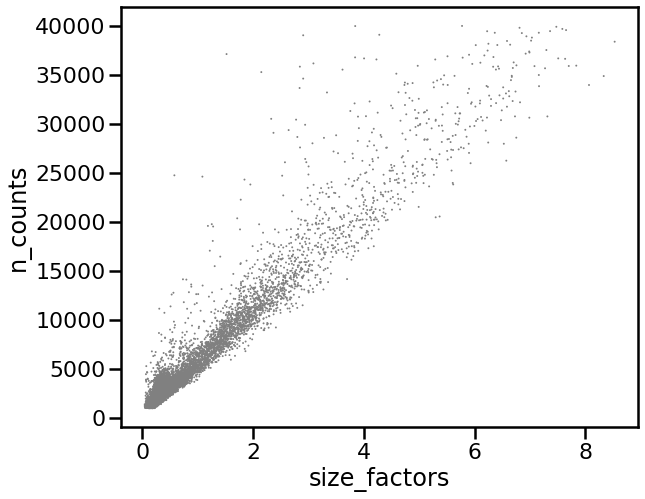

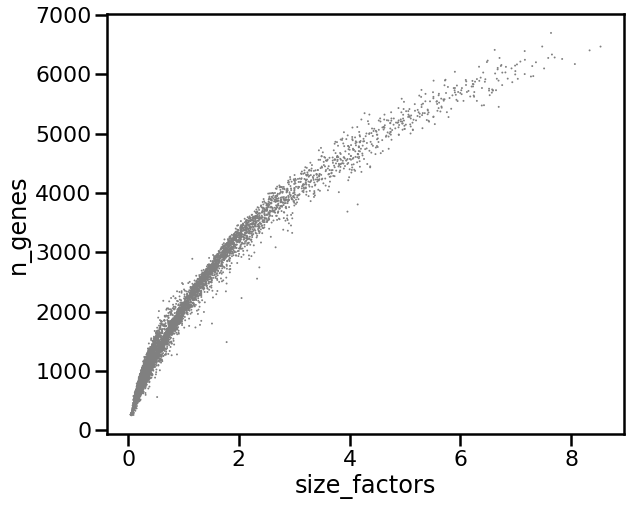

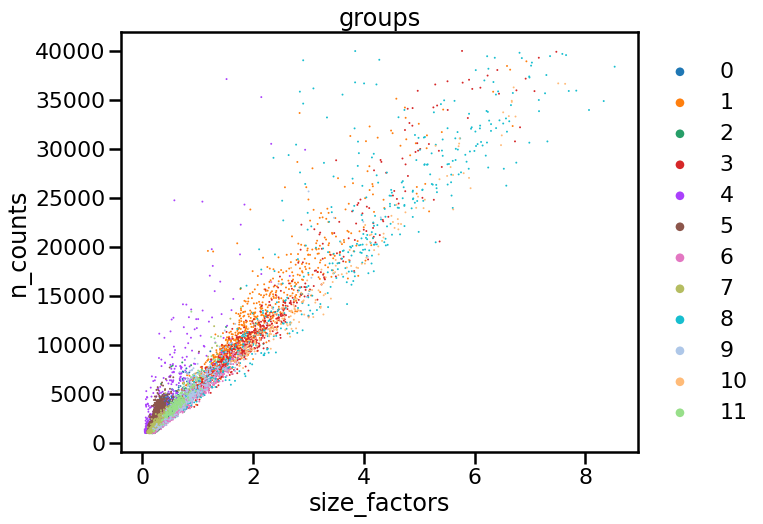

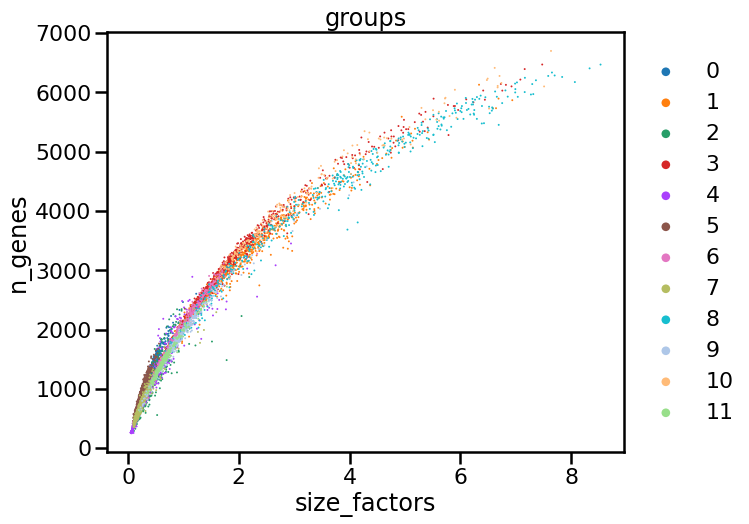

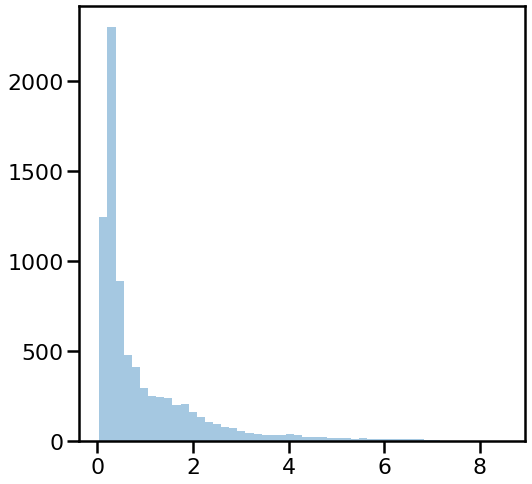

In [41]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors
adata_pp.obs['size_factors'] = size_factors

rcParams['figure.figsize']=(8,8)
sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sc.pl.scatter(adata_pp, 'size_factors', 'n_counts', color='groups')
sc.pl.scatter(adata_pp, 'size_factors', 'n_genes', color='groups')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [42]:
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)
adata.X = np.asarray(adata.X)

del adata_pp

In [44]:
adata.write('data/1_normalized.h5ad')

# Feature selection

In [61]:
adata=sc.read('data/1_normalized.h5ad')

In [62]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=2000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 2000


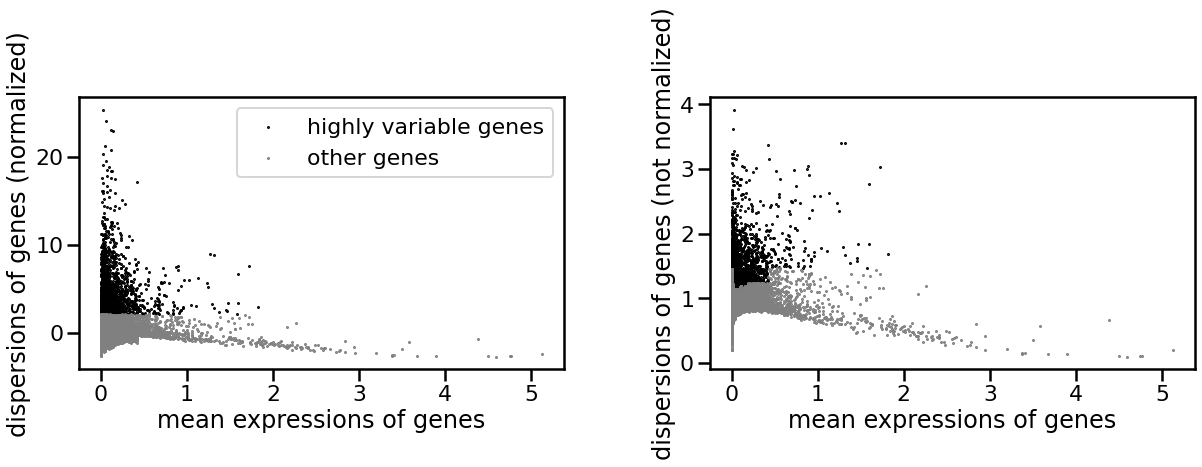

In [63]:
rcParams['figure.figsize']=(10,5)
sc.pl.highly_variable_genes(adata)

# Batch effect removal

In [67]:
sc.tl.pca(adata)
sce.pp.harmony_integrate(adata, 'batch')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)


2022-06-01 20:53:51,780 - harmonypy - INFO - Iteration 1 of 10
2022-06-01 20:53:53,070 - harmonypy - INFO - Iteration 2 of 10
2022-06-01 20:53:54,329 - harmonypy - INFO - Iteration 3 of 10
2022-06-01 20:53:55,511 - harmonypy - INFO - Converged after 3 iterations


In [68]:
'X_pca_harmony' in adata.obsm

True

# Clustering

In [56]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)


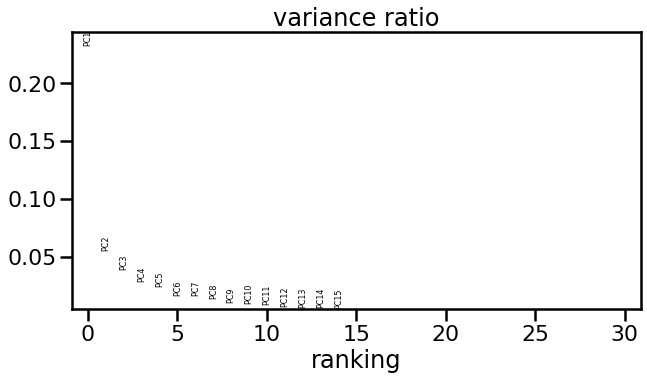

In [91]:
rcParams['figure.figsize']=(10,5)
sc.pl.pca_variance_ratio(adata) #find n_comps in figure through elbow method

In [88]:
sc.pp.pca(adata, n_comps=15, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.tsne(adata) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA
    on highly variable genes
    with n_comps=15
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing tSNE
    using 'X_pca' with n_pcs = 15
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:12)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9993592  0.9980333  0.9977476  0.9971866  0.9956316
     0.9953207  0.99377835 0.99166375 0.9864113  0.98214155 0.97973776
     0.97814703 0.9775184  0.9767561 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.

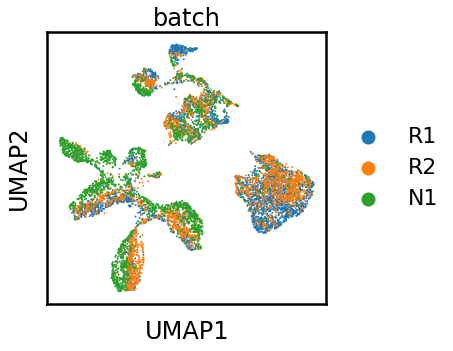

In [99]:
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata, color='batch')

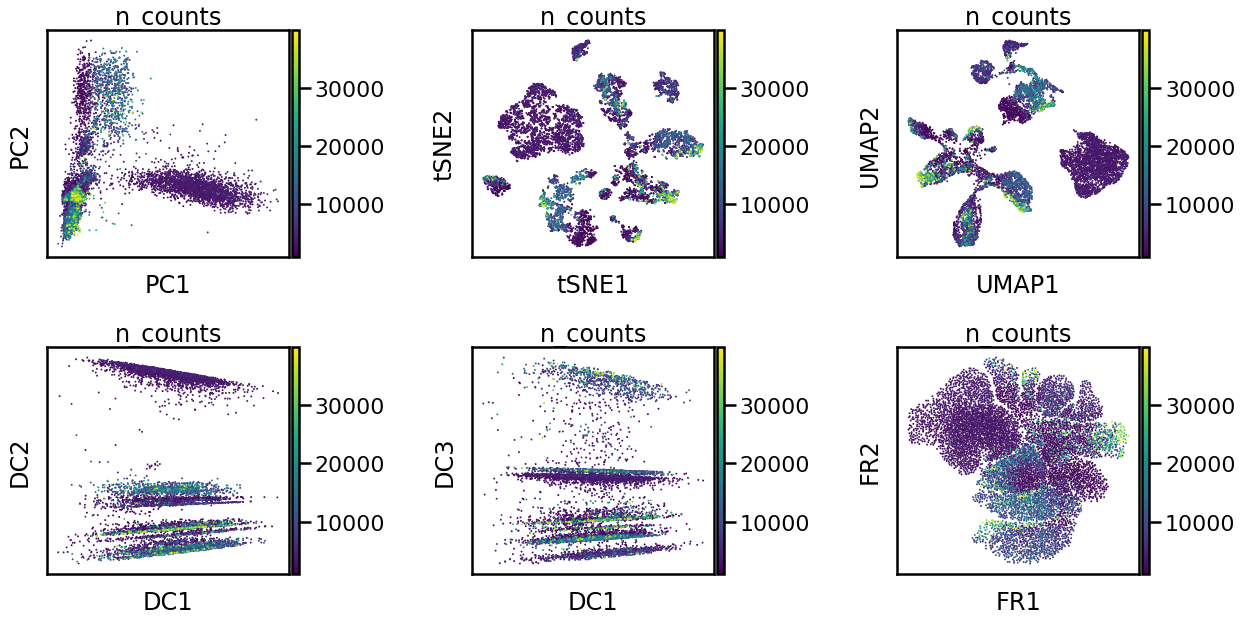

In [90]:
rcParams['figure.figsize']=(20,10)
fig_ind=np.arange(231, 237)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p10 = sc.pl.pca_scatter(adata, color='n_counts', ax=fig.add_subplot(fig_ind[0]), show=False)
p11 = sc.pl.tsne(adata, color='n_counts', ax=fig.add_subplot(fig_ind[1]), show=False)
p12 = sc.pl.umap(adata, color='n_counts', ax=fig.add_subplot(fig_ind[2]), show=False)
p13 = sc.pl.diffmap(adata, color='n_counts', components=['1,2'], ax=fig.add_subplot(fig_ind[3]),show=False)
p14 = sc.pl.diffmap(adata, color='n_counts', components=['1,3'], ax=fig.add_subplot(fig_ind[4]), show=False)
p15 = sc.pl.draw_graph(adata, color='n_counts', ax=fig.add_subplot(fig_ind[5]), show=False)

plt.show()

In [92]:
adata.write('data/2_clustered.h5ad')

# Neighboring

In [116]:
sc.tl.louvain(adata, resolution=1, key_added='louvain1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_05')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain1', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain_05', the cluster labels (adata.obs, categorical) (0:00:00)


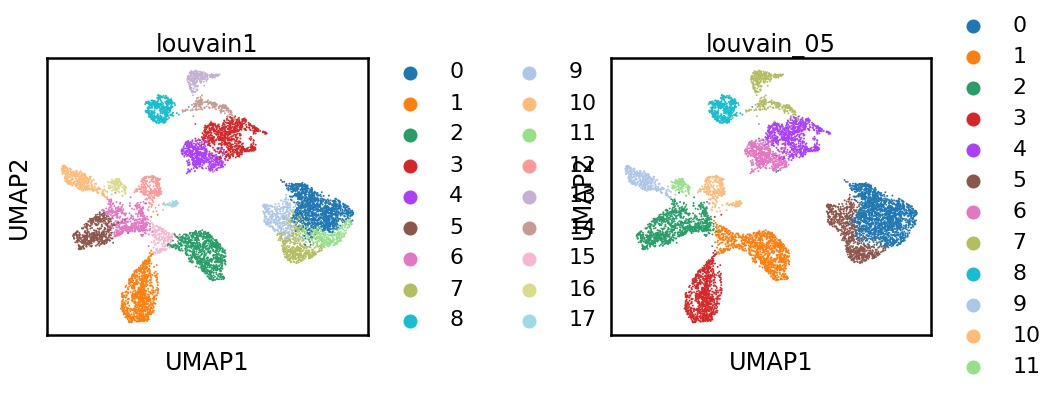

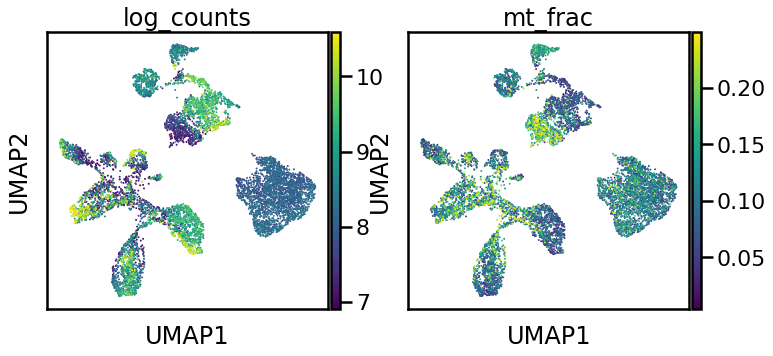

In [118]:
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata, color=['louvain1', 'louvain_05'], wspace=0.6)
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])

# Annotate in BBrowser

In [ ]:
adata.var_names = adata.var_names.str.upper()

In [119]:
adata.write('data/2_clustered.h5ad')

In [115]:
adata.obs.to_csv('data/annotations.csv')

In [123]:
#after label in bbrowser, import the annotated
label =pd.read_csv('data/annotated.tsv',sep='\t')
adata.obs['cell_type'] = label.celltype4.tolist()
adata.obs['group'] = adata.obs['batch'].replace({'R1': 'CRPC', 'R2':'CRPC', 'N1':'Non-treated'})
adata.obs['cell_type'].replace({'Seminal vesicles':'Epithelial'}, inplace=True)

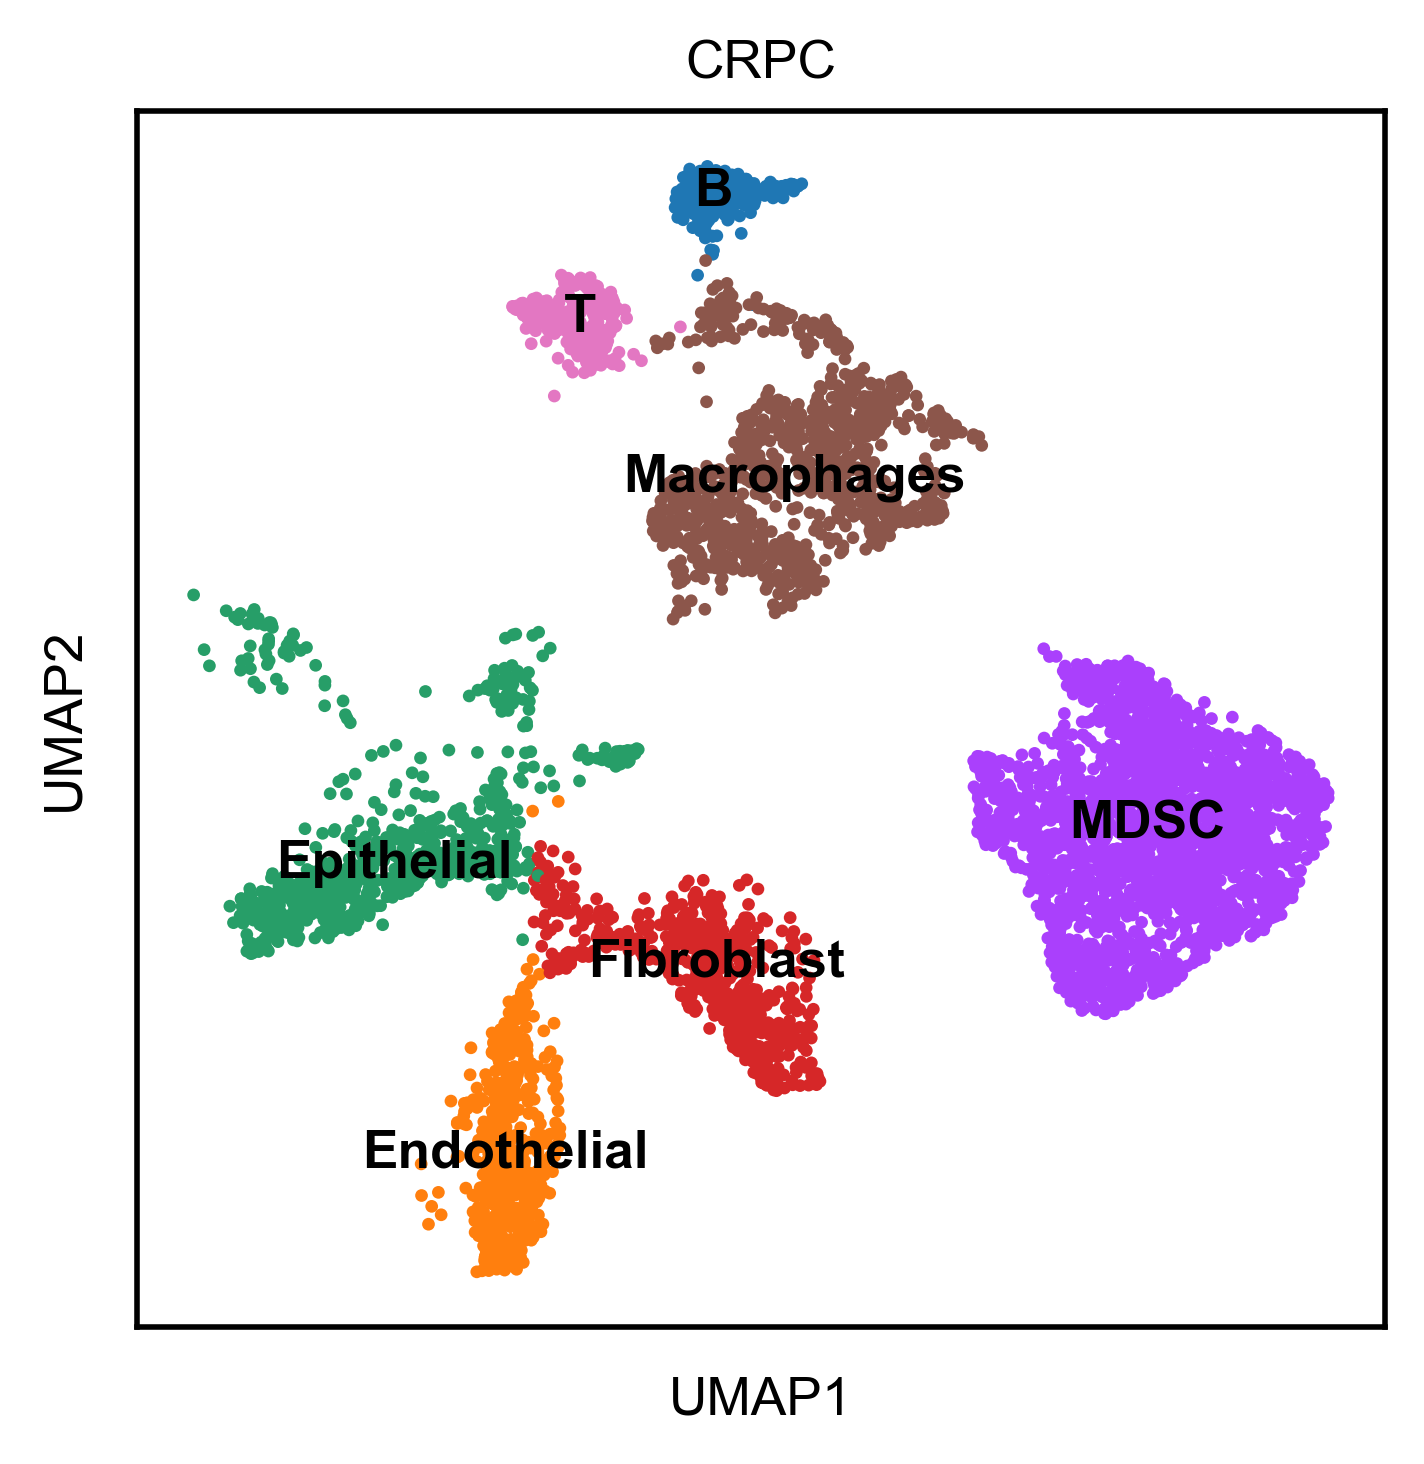

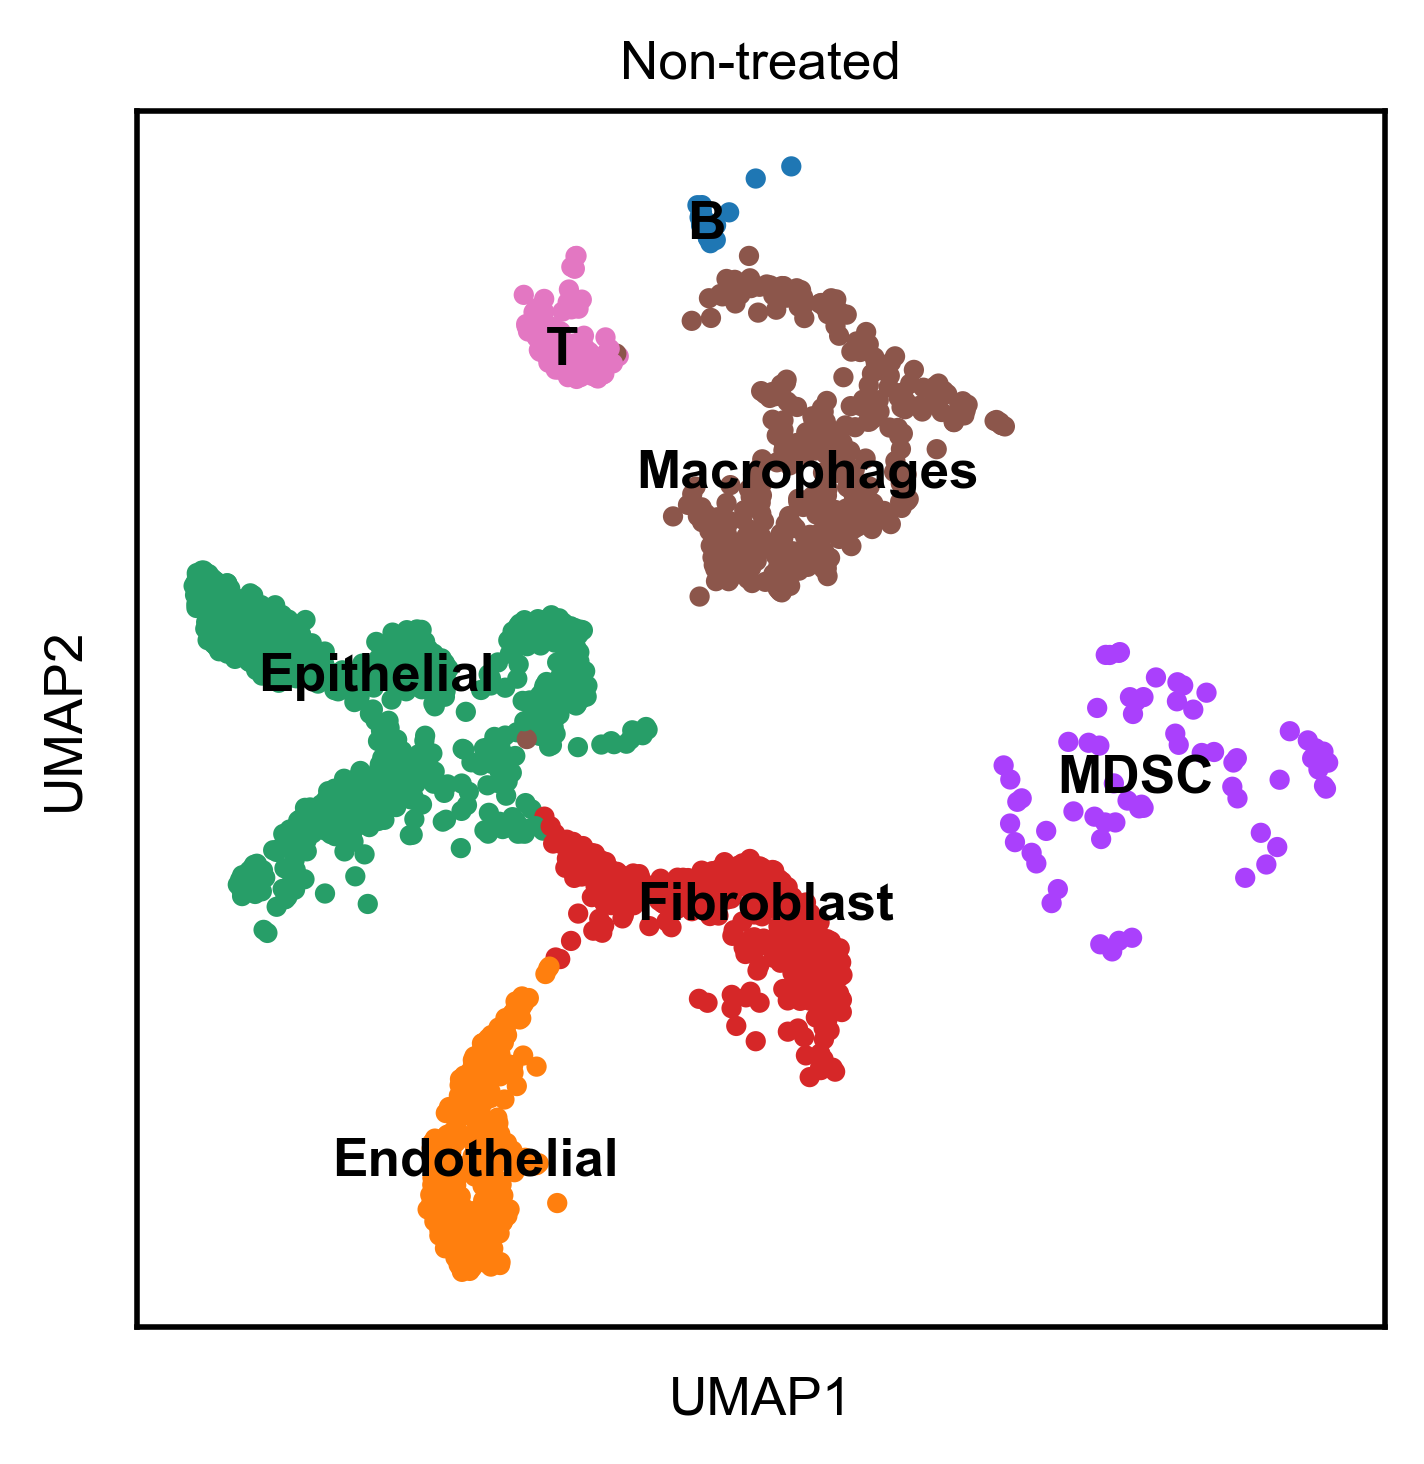

In [158]:
rcParams['figure.figsize']=(8,8)
sc.set_figure_params(dpi=200, dpi_save=300)
sb.set_context(context='paper')
sc.pl.umap(adata[adata.obs.group=='CRPC'], color=['cell_type'],legend_loc='on data',title='CRPC')
sc.pl.umap(adata[adata.obs.group!='CRPC'], color=['cell_type'], legend_loc='on data',title='Non-treated')

In [159]:
adata.write('data/3_annotated.h5ad')

In [164]:
#check using ENS in bbrowser again
adata.var.set_index('gene_ids',inplace=True)
adata.write('data/3_annotated_ENS.h5ad')

In [4]:
adata = sc.read('data/3_annotated_ENS.h5ad')

In [7]:
adata.obs.to_csv('data/annotations2.csv', index=True)